In [2]:
%reset -f
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
pylab.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import Portfolio.PortHelper as ph
from Backtester import SignalHelper as sh
from statsmodels.distributions.empirical_distribution import ECDF

In [23]:
assets_df = pd.read_csv('S:\Github\MyProjects\SystematicWork\sbc_data.csv',
                    index_col=0)
assets = assets_df.columns

In [27]:
def get_sims(w_port, T, M):
    global assets_df
    sims = sh.get_sb_samples(assets_df.values, M=M, T=T)
    port_sims = np.zeros((T, M))
    for ix in range(M):
        port_sims[:, ix] = sims[:, :, ix] @ w_port

    scenarios_df = pd.concat(
        [pd.DataFrame(np.repeat(1, M)).T, 1+pd.DataFrame(port_sims)],
        axis=0).reset_index(drop=True).cumprod()
    scenarios_df.index = scenarios_df.index/12

    drawdown_df = scenarios_df.divide(scenarios_df.cummax())-1
    rx_df = (scenarios_df.iloc[-1,:])**(12/T)-1
    sharpe_df = scenarios_df.pct_change().apply(lambda x: x.mean()/x.std())
    maxdd_df = drawdown_df.min().abs()

    stats_df = pd.concat([rx_df, sharpe_df, maxdd_df], axis=1).apply(get_quantiles)
    stats_df.columns = ['Excess Return', 'Sharpe Ratio', 'Max Drawdown']

    return scenarios_df, drawdown_df, rx_df, sharpe_df, maxdd_df, stats_df


def get_quantiles(x):
    qs = np.quantile(x, [0.05, 0.15, 0.25, 0.35, 0.45, 0.50, 
                         0.55, 0.65, 0.75, 0.85, 0.95])
    return pd.Series(qs, index=['5%', '15%', '25%', '35%',
                                '45%', '50%', '55%', '65%', '75%', '85%', 
                                '95%'])

def plot_stats():
    
    plt.close()
    upper_con_sims = scenarios_df.apply(np.log).apply(lambda x: np.percentile(x, 95), axis=1)
    median_con_sims = scenarios_df.apply(np.log).apply(lambda x: np.median(x), axis=1)
    lower_con_sims = scenarios_df.apply(np.log).apply(lambda x: np.percentile(x, 5), axis=1)

    f, ax = plt.subplots(figsize=(18,12))
    scenarios_df.apply(np.log).iloc[:, np.random.randint(0, M, 50)].plot(legend=False,
                                                                         alpha=0.6,
                                                                         color='grey', 
                                                                         ax=ax)
    median_con_sims.plot(color='black', lw=2.5)
    upper_con_sims.plot(color='blue', lw=2.5)
    lower_con_sims.plot(color='red', lw=2.5)

    plt.fill_between(x=median_con_sims.index, 
                     y1=upper_con_sims, 
                     y2=median_con_sims,
                     color='blue', alpha=0.3)
    plt.fill_between(x=median_con_sims.index,
                     y1=lower_con_sims, 
                     y2=median_con_sims, 
                     color='red', alpha=0.3)

    plt.title('Stress Tested Scenarios: (with 5th & 95th Percentile Confidence Interval)', fontsize=15)
    plt.xlim([0, T/12])
    plt.xlabel('Years Ahead')
    plt.ylabel('Cumulative Return')

    f, ax = plt.subplots(figsize=(18,12))
    l_dd = drawdown_df.apply(lambda x: np.percentile(x, 5), axis=1) * 100
    l_dd.plot(color='crimson', lw=3)
    plt.axhline(y=0, color='black', lw=2, linestyle='--')
    plt.fill_between(x=drawdown_df.index, y1=0, y2=l_dd,
                     alpha=0.3, color='crimson')
    plt.ylim([None,0])
    plt.title('Worst Case Drawdown - 5th Percentile', fontsize=15)
    plt.xlabel('Years Ahead')

    f, ax = plt.subplots(figsize=(18,12))
    (rx_df*100).plot(kind='hist',  density=True,
                  color='darkred', alpha=0.35, edgecolor='black', bins=50, ax=ax)
    plt.title('Excess Returns Distribution')
    plt.xlabel('Compounded Excess Returns %')

    f, ax = plt.subplots(figsize=(18,12))
    sharpe_df.plot(kind='hist',  density=True,
                  color='darkblue', alpha=0.35, edgecolor='black', bins=50, ax=ax)
    plt.title('Sharpe Ratio Distribution')

    f, ax = plt.subplots(figsize=(18,12))
    (maxdd_df*100).plot(kind='hist',  density=True,
                  color='darkblue', alpha=0.35, edgecolor='black', bins=50, ax=ax)
    plt.title('Maximum Drawdown Distribution')
    plt.xlabel('Maximum Drawdown %')
    


In [111]:
w_port = np.array([0.52,0.28,0.20])
T = 120
M = 5000
tgts = [-0.06, -0.025, 0.02, 0.075, 0.08]
sharpe_tgts = [-0.2, -0.1, 0.0, 0.4, 0.5]

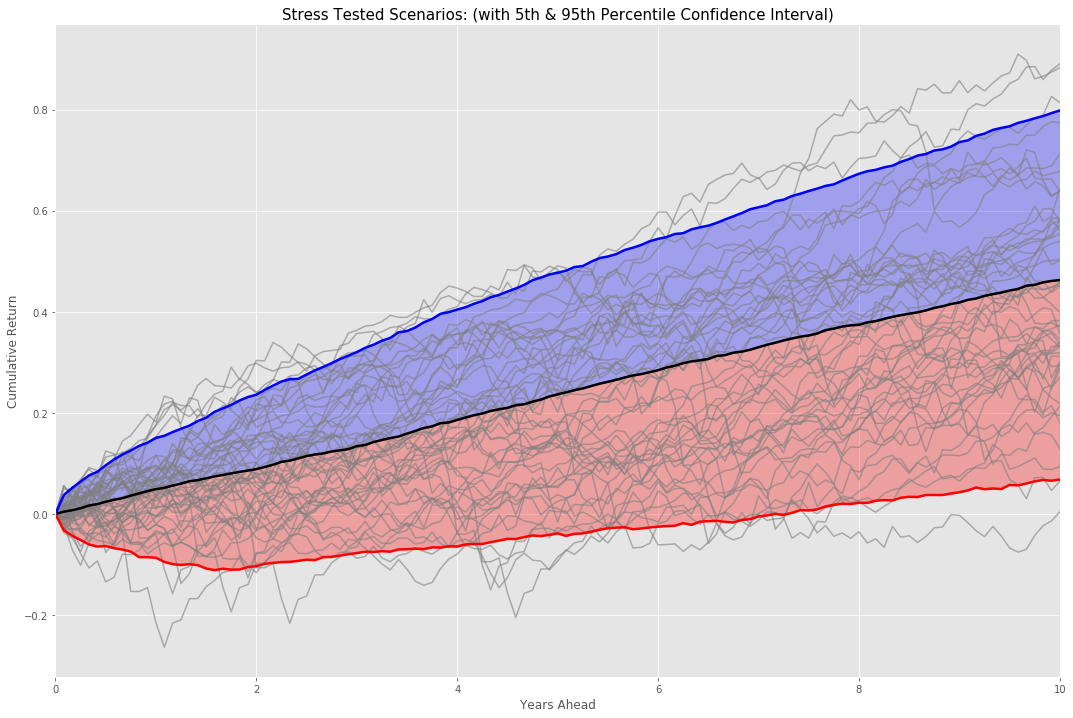

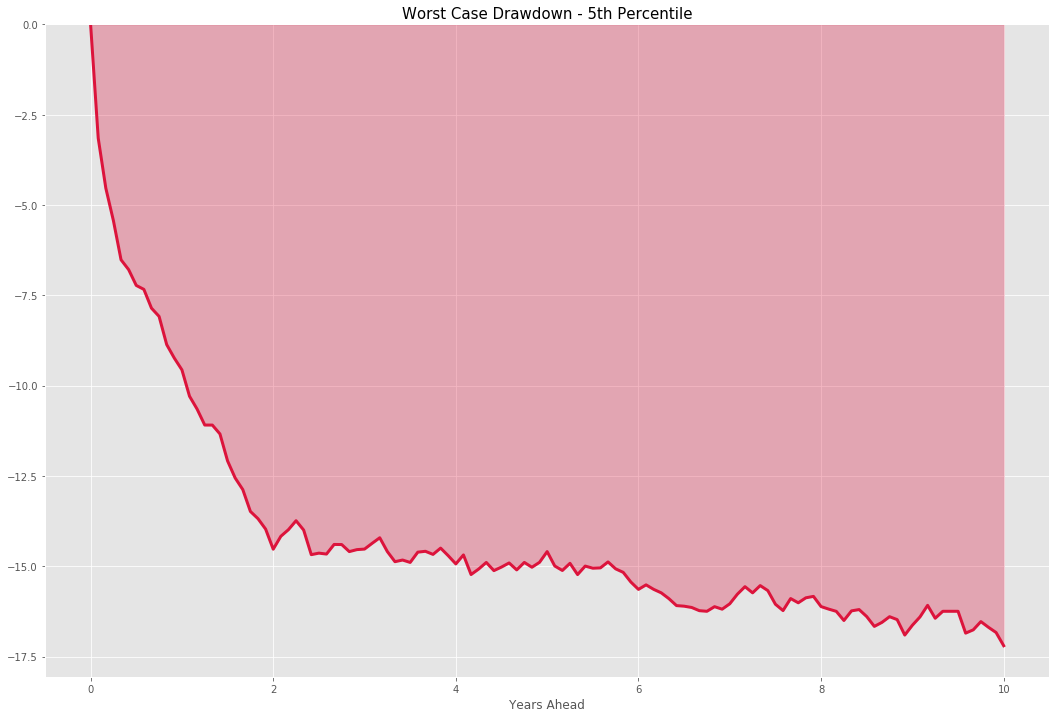

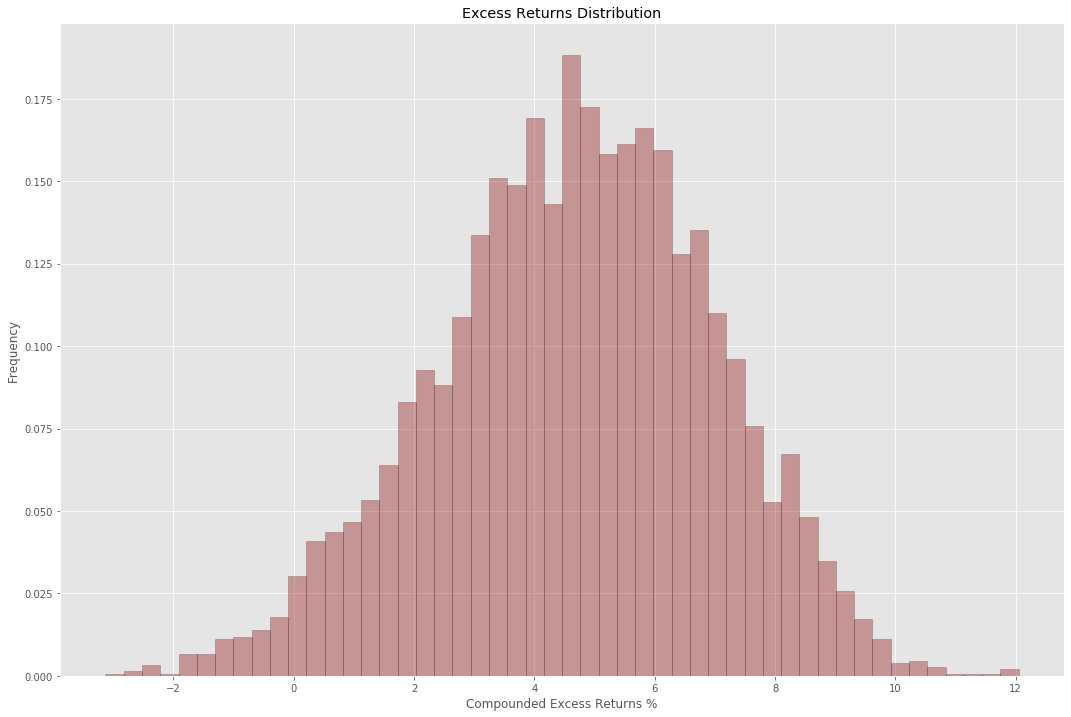

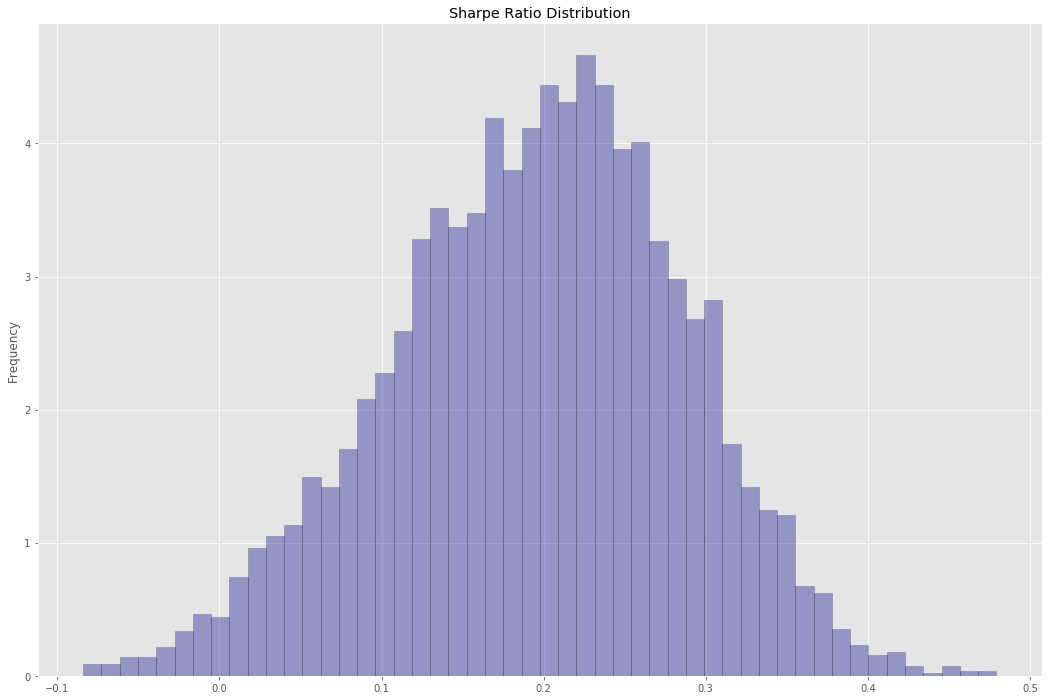

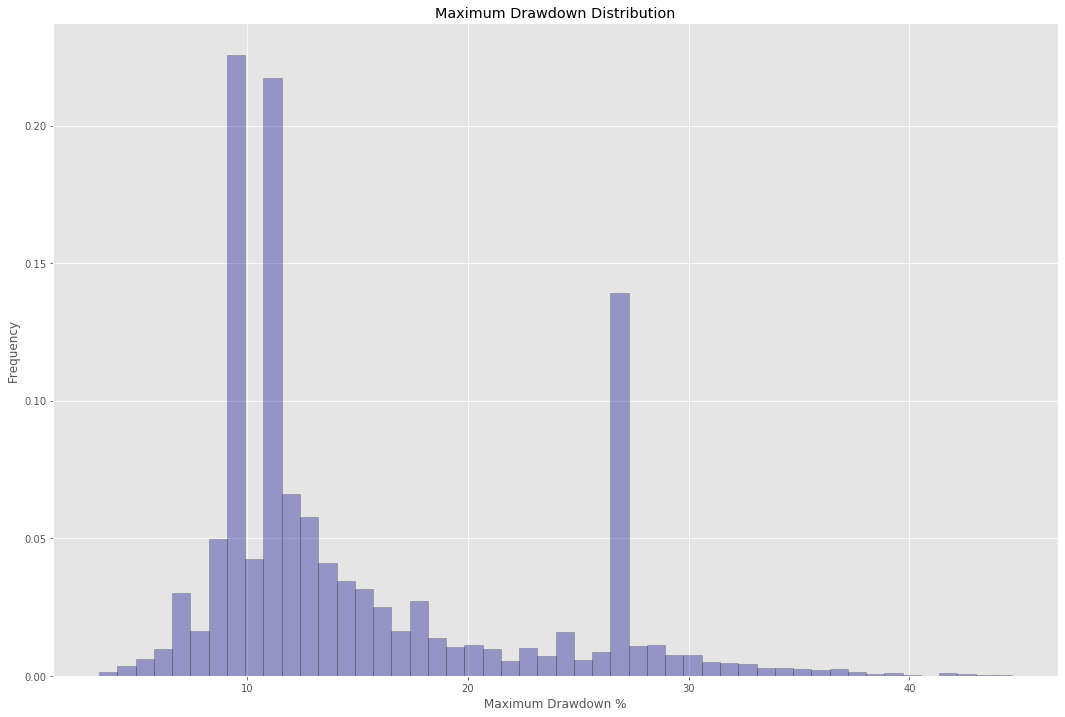

In [112]:
scenarios_df, drawdown_df, rx_df, sharpe_df, maxdd_df, stats_df = get_sims(w_port, T, M)
rx_ecdf = ECDF(rx_df)
sharpe_ecdf = ECDF(sharpe_df)
maxdd_ecdf = ECDF(maxdd_df)    
plot_stats()

In [113]:
stats_df

,Excess Return,Sharpe Ratio,Max Drawdown
5%,0.006848,0.037486,0.078833
15%,0.022196,0.100625,0.095296
25%,0.031599,0.134981,0.095296
35%,0.038372,0.163975,0.112387
45%,0.044727,0.189173,0.113652
50%,0.047363,0.201274,0.116084
55%,0.050326,0.211847,0.123618
65%,0.056556,0.234404,0.144887
75%,0.062708,0.258095,0.184214
85%,0.070532,0.289109,0.265794


In [114]:
prob_df = pd.DataFrame([ rx_ecdf(tgts)]).T
prob_df.index = tgts
prob_df.columns = ['Prob(rx <= rx_hat)']
prob_df

,Prob(rx <= rx_hat)
-0.060,0.0000
-0.025,0.0006
0.020,0.1292
0.075,0.8950
0.080,0.9288


In [115]:
prob_df = pd.DataFrame([sharpe_ecdf(sharpe_tgts)]).T
prob_df.index = sharpe_tgts
prob_df.columns = ['Prob(SR <= SR_hat)']
prob_df

,Prob(SR <= SR_hat)
-0.2,0.0000
-0.1,0.0000
0.0,0.0182
0.4,0.9934
0.5,1.0000


In [116]:
w_port = np.array([0.40,0.60,0.0])
T = 120
M = 5000
tgts = [-0.06, -0.025, 0.02, 0.075, 0.08]
sharpe_tgts = [-0.2, -0.1, 0.0, 0.4, 0.5]

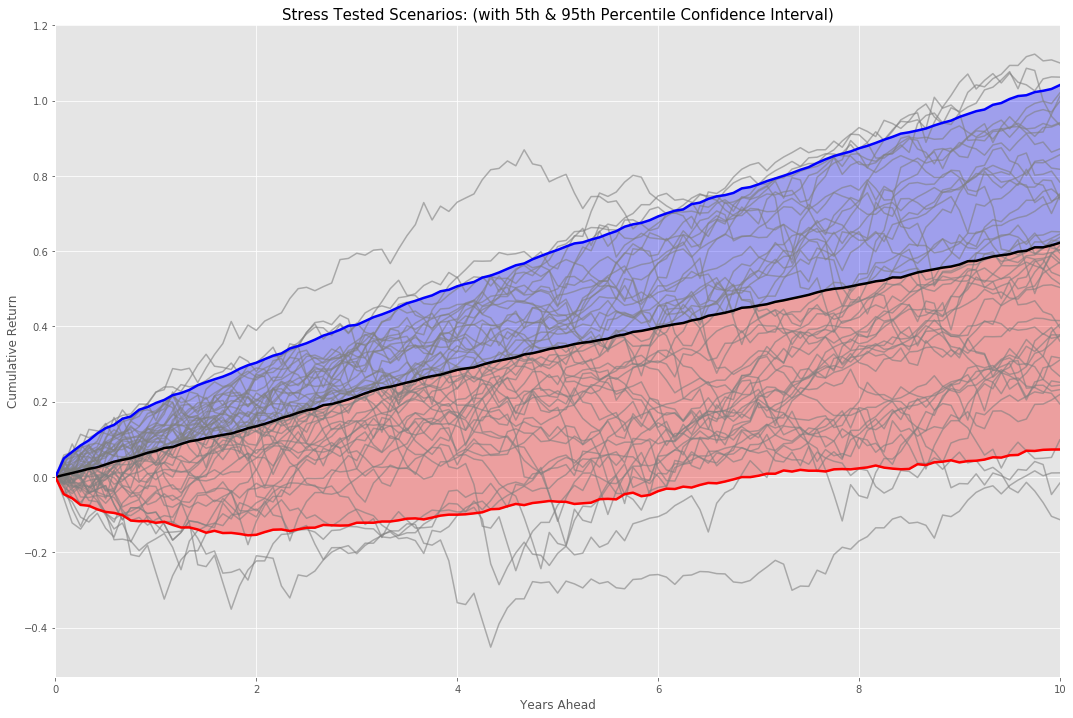

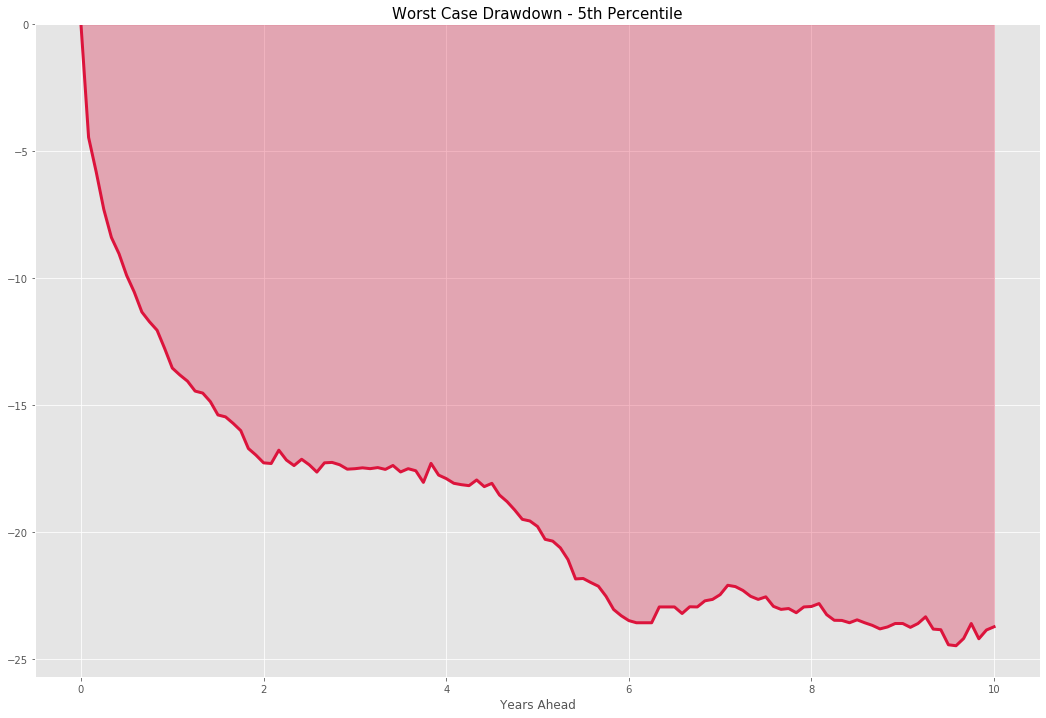

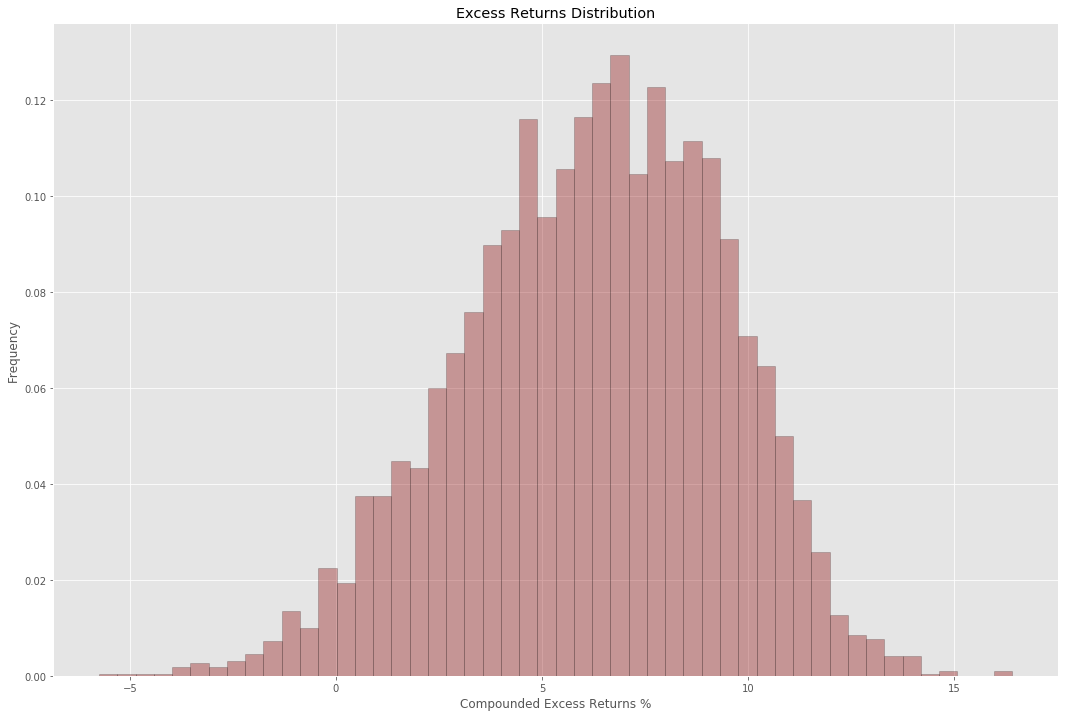

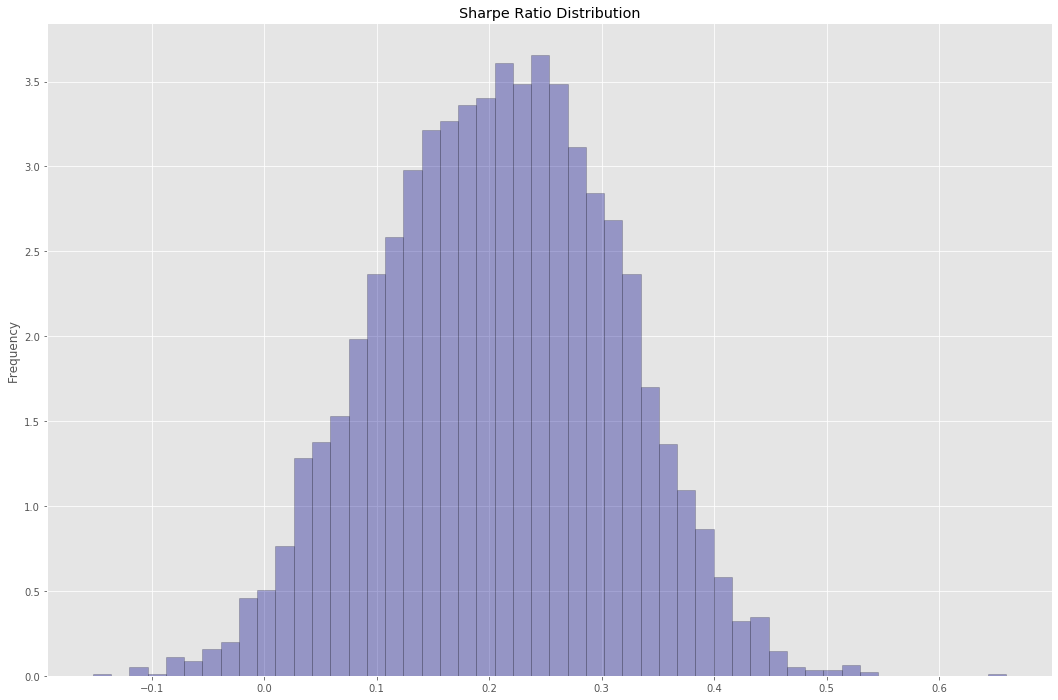

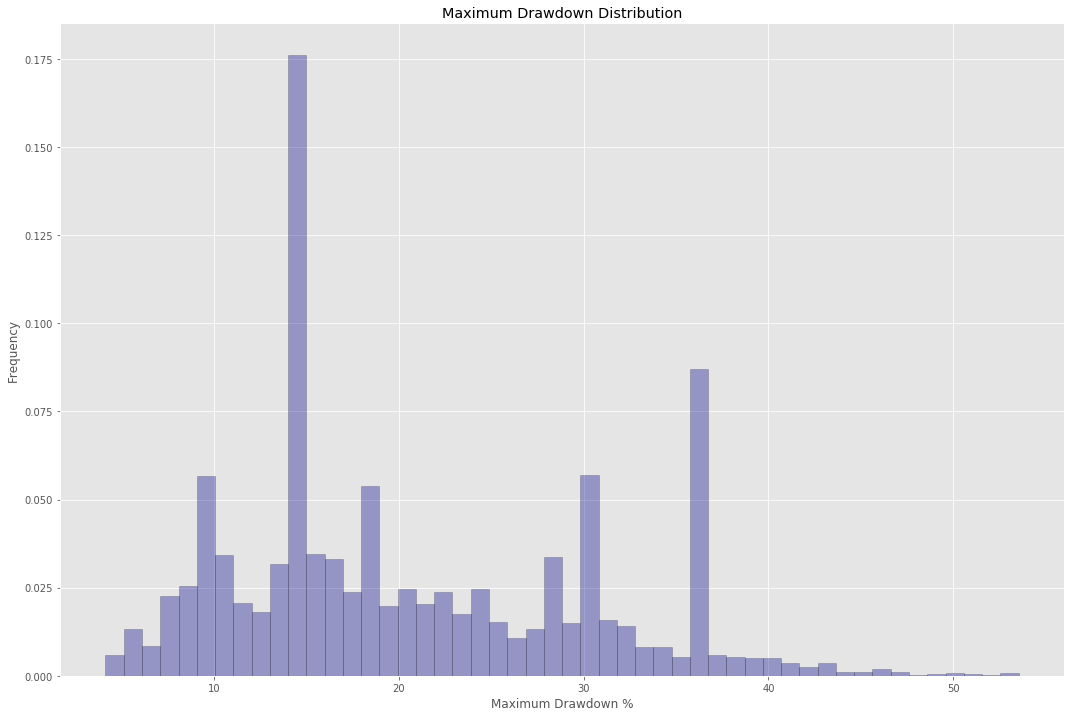

In [117]:
scenarios_df, drawdown_df, rx_df, sharpe_df, maxdd_df, stats_df = get_sims(w_port, T, M)
rx_ecdf = ECDF(rx_df)
sharpe_ecdf = ECDF(sharpe_df)
maxdd_ecdf = ECDF(maxdd_df)    
plot_stats()

In [118]:
stats_df

,Excess Return,Sharpe Ratio,Max Drawdown
5%,0.007346,0.035668,0.081511
15%,0.028457,0.096712,0.107010
25%,0.040828,0.134645,0.140074
35%,0.050574,0.164648,0.140074
45%,0.060125,0.195198,0.162877
50%,0.064201,0.210285,0.180163
55%,0.068138,0.223362,0.189465
65%,0.076788,0.251680,0.233363
75%,0.085633,0.282258,0.286146
85%,0.094882,0.317220,0.325550


In [119]:
prob_df = pd.DataFrame([ rx_ecdf(tgts)]).T
prob_df.index = tgts
prob_df.columns = ['Prob(rx <= rx_hat)']
prob_df

,Prob(rx <= rx_hat)
-0.060,0.0000
-0.025,0.0038
0.020,0.1012
0.075,0.6290
0.080,0.6890


In [120]:
prob_df = pd.DataFrame([sharpe_ecdf(sharpe_tgts)]).T
prob_df.index = sharpe_tgts
prob_df.columns = ['Prob(SR <= SR_hat)']
prob_df

,Prob(SR <= SR_hat)
-0.2,0.0000
-0.1,0.0010
0.0,0.0196
0.4,0.9738
0.5,0.9978
